In [1]:
import h5py as h5
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from auton_survival.preprocessing import Scaler
import optuna
from sklearn.model_selection import ParameterGrid
#sys.path.append('/projects/EKOLEMEN/survival_tm/train_models/auton-survival')
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm import DeepSurvivalMachines
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from sklearn.decomposition import PCA

/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
tm_data = h5.File('/projects/EKOLEMEN/survival_tm/tm_labels.h5', 'r')
print(tm_data['180636'].keys())
print(tm_data['180636']['label'][:])

<KeysViewHDF5 ['has_tm', 'label', 'time']>
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
with open('data/cake_normalizations_dict.pkl', 'rb') as f:
    normalizations = pickle.load(f)

print(normalizations)

{'bmspinj': {'mean': 5.482950287257639, 'std': 2.667591547466661}, 'bmstinj': {'mean': 3.624859979467065, 'std': 2.192277087820914}, 'betan_EFITRT2': {'mean': 1.8685360389457155, 'std': 0.7193194502857477}, 'qmin_EFITRT2': {'mean': 1.4422130158062725, 'std': 0.7708945979115958}, 'ech_pwr_total': {'mean': 780373.5298932531, 'std': 1166218.2471765294}, 'ip': {'mean': 888936.2638901811, 'std': 609874.8954300353}, 'PCBCOIL': {'mean': -0.5966564799506661, 'std': 1.7845868058705807}, 'li_EFITRT2': {'mean': 0.9313415848445893, 'std': 0.20288680895132727}, 'aminor_EFITRT2': {'mean': 0.5861878665129585, 'std': 0.02030179972760069}, 'rmaxis_EFITRT2': {'mean': 1.7624798953165388, 'std': 0.03789558542637226}, 'tribot_EFITRT2': {'mean': 0.2011931107911801, 'std': 0.2724185976918507}, 'tritop_EFITRT2': {'mean': 0.1898694540478942, 'std': 0.265364687500663}, 'kappa_EFITRT2': {'mean': 1.801520338705566, 'std': 0.09104860136805752}, 'volume_EFITRT2': {'mean': 18.310347796920016, 'std': 0.99501953384335

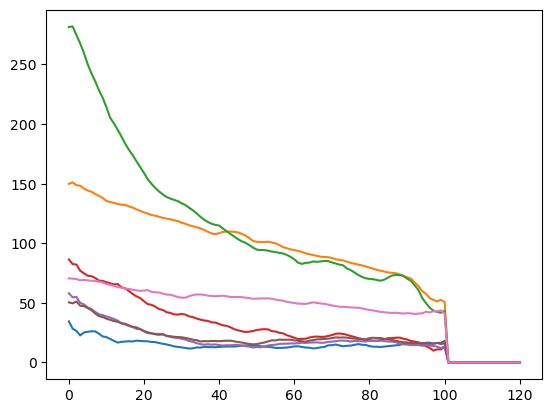

In [54]:
with open('data/cakenn_output.pkl', 'rb') as f:
    cakenn_output = pickle.load(f)
for i in range(7):  
    plt.plot(cakenn_output['data'][i,:,6])
cakenn_output_order = ['p [kPa]', '1/q', r'j [MA m$^{-2}$]', r'n$_e$ [10$^{19}$ m$^{-3}$]', r'T$_e$ [keV]', r'T$_i$ [keV]', r'V$_{tor}$ [km/s]']
wanted_order = ['Te', 'Ti', 'ne', 'Vtor', '1/q', 'p', 'j']
new_order_cakenn = np.zeros((7, 121, 7))
new_order_cakenn[:,:,0] = cakenn_output['data'][:,:,4]
new_order_cakenn[:,:,1] = cakenn_output['data'][:,:,5]
new_order_cakenn[:,:,2] = cakenn_output['data'][:,:,3]
new_order_cakenn[:,:,3] = cakenn_output['data'][:,:,6]
new_order_cakenn[:,:,4] = cakenn_output['data'][:,:,1]
new_order_cakenn[:,:,5] = cakenn_output['data'][:,:,0]
new_order_cakenn[:,:,6] = cakenn_output['data'][:,:,2]
new_order_cakenn = np.transpose(new_order_cakenn, (0, 2, 1))   
reformatted_cakenn = np.zeros((7, 121*7))
for i in range(7):
    reformatted_cakenn[i,:] = new_order_cakenn[i,:,:].flatten()

# add zeros to the first 14 elements of the data at each of the 7 times
reformatted_cakenn = np.concatenate((np.zeros((7, 14)), reformatted_cakenn), axis=1)

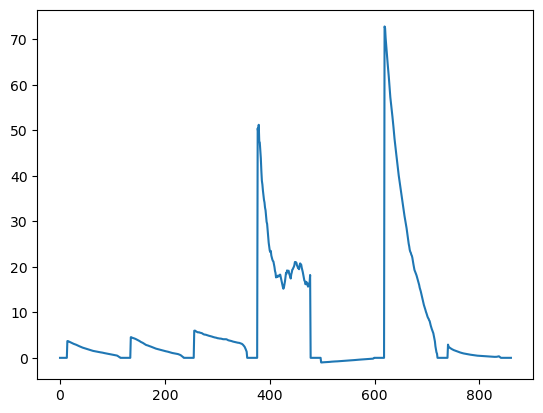

In [56]:
plt.plot(reformatted_cakenn[5,:])

In [85]:
shot = '198861'
with open('data/shot_198861.pkl', 'rb') as f:
    data = pickle.load(f)

prof_signals = ['thomson_temp_mtanh_1d', 'cer_temp_csaps_1d', 'thomson_density_mtanh_1d', 'cer_rot_csaps_1d', 'qpsi_EFITRT2', 'pres_EFITRT2']

signals = ['bmspinj', 'bmstinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 'ip', 'PCBCOIL', 'li_EFITRT2', 'aminor_EFITRT2', 
          'rmaxis_EFITRT2', 'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2']

def check_all_signals(shot_data, prof_signals, signals, ind):
    # Check scalars for nan values
    for sig in signals:
        if np.isnan(shot_data[sig][ind]):
            return False
    
    # Check profiles for nan values
    for sig in prof_signals:
        if np.sum(np.isnan(shot_data[sig][ind,:])) > 0:
            return False
       
    return True

def gather_feature(shot_data, prof_signals, signals, ind):
    feature = np.zeros(len(prof_signals)*33+len(signals))
    
    # Load scalar signals
    for i, sig in enumerate(signals):
        feature[i] = shot_data[sig][ind]
    
    # Load profile signals
    for i, sig in enumerate(prof_signals):
        feature[33*i+len(signals):33*(i+1)+len(signals)] = shot_data[sig][ind,:]
    
    return feature

x = []

times = np.arange(0, 6000, 20)[::-1]
# I should check the timesteps are the same for all scalars


# Find start and stop of flattop

# Get start and stop inds
start_ind = 0
end_ind = 300
# Go through valid indices and gather dataset
for ind in range(start_ind, end_ind):
    # Check that we have all signals at this time
    if check_all_signals(data[shot], prof_signals, signals, ind):
        feature = gather_feature(data[shot], prof_signals, signals, ind)
        x.append(feature)
        

In [81]:
### PCA tester
'''
with open('data/cakenn_filtered_x_bms_pcb.pkl', 'rb') as f:
    cake_raw = pickle.load(f)'''
with open('data/cakenn__filtered_x_pca_bms_pcb.pkl', 'rb') as f:
    cake_pca = pickle.load(f)
with open('data/cakenn_filtered_pca_components_bms_pcb.pkl', 'rb') as f:
    pca_components = pickle.load(f)
with open('data/cakenn_filtered_normalizations_bms_pcb.pkl', 'rb') as f:
    normalizations = pickle.load(f)

x_train_df = reformatted_cakenn
# separate each normalized profile
scalars = x_train_df[:, 0:14]
j = x_train_df[:, 14:14+121]
ne = x_train_df[:, 14+121:14+121*2]
p = x_train_df[:, 14+121*2:14+121*3]
qinv = x_train_df[:, 14+121*3:14+121*4]
te = x_train_df[:, 14+121*4:14+121*5]
ti = x_train_df[:, 14+121*5:14+121*6]
vtor = x_train_df[:, 14+121*6:14+121*7]

# Fit PCA on the data
pca = PCA(n_components=4)
pca.components_ = pca_components[0]
pca.mean_ = pca_components[1]
j_pca = pca.transform(j)

pca = PCA(n_components=4)
pca.components_ = pca_components[2]
pca.mean_ = pca_components[3]
ne_pca = pca.transform(ne)


pca = PCA(n_components=4)
pca.components_ = pca_components[4]
pca.mean_ = pca_components[5]
p_pca = pca.transform(p)


pca = PCA(n_components=4)
pca.components_ = pca_components[6]
pca.mean_ = pca_components[7]
qinv_pca = pca.transform(qinv)

pca = PCA(n_components=4)
pca.components_ = pca_components[8]
pca.mean_ = pca_components[9]
te_pca = pca.transform(te)

pca = PCA(n_components=4)
pca.components_ = pca_components[10]
pca.mean_ = pca_components[11]
ti_pca = pca.transform(ti)


pca = PCA(n_components=4)
pca.components_ = pca_components[12]
pca.mean_ = pca_components[13]
vtor_pca = pca.transform(vtor)


# normalize PCA components

scalars_mean = normalizations[0][0]
scalars_std = normalizations[0][1]

scalars_normed = (scalars - scalars_mean)/scalars_std

j_pca_mean = normalizations[1][0]
j_pca_std = normalizations[1][1]
j_pca_normed = (j_pca - j_pca_mean)/j_pca_std

ne_pca_mean = normalizations[2][0]
ne_pca_std = normalizations[2][1]
ne_pca_normed = (ne_pca - ne_pca_mean)/ne_pca_std

p_pca_mean = normalizations[3][0]
p_pca_std = normalizations[3][1]
p_pca_normed = (p_pca - p_pca_mean)/p_pca_std

qinv_pca_mean = normalizations[4][0]
qinv_pca_std = normalizations[4][1]
qinv_pca_normed = (qinv_pca - qinv_pca_mean)/qinv_pca_std

te_pca_mean = normalizations[5][0]
te_pca_std = normalizations[5][1]
te_pca_normed = (te_pca - te_pca_mean)/te_pca_std

ti_pca_mean = normalizations[6][0]
ti_pca_std = normalizations[6][1]
ti_pca_normed = (ti_pca - ti_pca_mean)/ti_pca_std

vtor_pca_mean = normalizations[7][0]
vtor_pca_std = normalizations[7][1]
vtor_pca_normed = (vtor_pca - vtor_pca_mean)/vtor_pca_std
x_train_pca_unnormed = np.concatenate((scalars, j_pca, ne_pca, p_pca, qinv_pca, te_pca, ti_pca, vtor_pca), axis=1)
x_train_pca = pd.DataFrame(np.concatenate((scalars_normed, j_pca_normed, ne_pca_normed, p_pca_normed, qinv_pca_normed, te_pca_normed, ti_pca_normed, vtor_pca_normed), axis=1))


In [86]:
### PCA tester

'''with open('data/rt_filtered_x_bms_pcb_rot.pkl', 'rb') as f:
    rt_raw = pickle.load(f)
with open('data/rt_x_pca_bms_pcb_rot.pkl', 'rb') as f:
    rt_pca = pickle.load(f)'''
with open('data/rt_pca_components_bms_pcb.pkl', 'rb') as f:
    pca_components = pickle.load(f)
with open('data/rt_normalizations_bms_pcb.pkl', 'rb') as f:
    normalizations = pickle.load(f)

with open('data/rt_pca_components_bms_pcb_rot.pkl', 'rb') as f:
    pca_components_rot = pickle.load(f)
with open('data/rt_normalizations_bms_pcb_rot.pkl', 'rb') as f:
    normalizations_rot = pickle.load(f)

prof_signals = ['thomson_temp_mtanh_1d', 'cer_temp_csaps_1d', 'thomson_density_mtanh_1d', 'cer_rot_csaps_1d', 'qpsi_EFITRT2', 'pres_EFITRT2']

x_train_df = np.array(x)
# separate each normalized profile
scalars = x_train_df[:, 0:14]
j = x_train_df[:, 14:14+33]
ne = x_train_df[:, 14+33:14+33*2]
p = x_train_df[:, 14+33*2:14+33*3]
qinv = x_train_df[:, 14+33*3:14+33*4]
te = x_train_df[:, 14+33*4:14+33*5]
te = 1/te
te = np.where(te == np.inf, 1, te)
ti = x_train_df[:, 14+33*5:14+33*6]

x_old = np.linspace(0, 1, 33)
x_long = np.linspace(0, 1, 100)
x_for_q = np.linspace(0, 1, 65)
j = np.array([np.interp(x_long, x_old, j[i]) for i in range(len(j))])
ne = np.array([np.interp(x_long, x_old, ne[i]) for i in range(len(ne))])
p = np.array([np.interp(x_long, x_old, p[i]) for i in range(len(p))])
qinv = np.array([np.interp(x_long, x_old, qinv[i]) for i in range(len(qinv))])
te = np.array([np.interp(x_for_q, x_old, te[i]) for i in range(len(te))])
ti = np.array([np.interp(x_for_q, x_old, ti[i]) for i in range(len(ti))])

# Fit PCA on the data
pca = PCA(n_components=4)
pca.components_ = pca_components[0]
pca.mean_ = pca_components[1]
j_pca = pca.transform(j)

pca = PCA(n_components=4)
pca.components_ = pca_components[2]
pca.mean_ = pca_components[3]
ne_pca = pca.transform(ne)


pca = PCA(n_components=4)
pca.components_ = pca_components[4]
pca.mean_ = pca_components[5]
p_pca = pca.transform(p)


pca = PCA(n_components=4)
pca.components_ = pca_components_rot[0]
pca.mean_ = pca_components_rot[1]
qinv_pca = pca.transform(qinv)

pca = PCA(n_components=4)
pca.components_ = pca_components[8]
pca.mean_ = pca_components[9]
te_pca = pca.transform(te)

pca = PCA(n_components=4)
pca.components_ = pca_components[10]
pca.mean_ = pca_components[11]
ti_pca = pca.transform(ti)

# normalize PCA components

scalars_mean = normalizations[0][0]
scalars_std = normalizations[0][1]

scalars_normed = (scalars - scalars_mean)/scalars_std

j_pca_mean = normalizations[1][0]
j_pca_std = normalizations[1][1]
j_pca_normed = (j_pca - j_pca_mean)/j_pca_std

ne_pca_mean = normalizations[2][0]
ne_pca_std = normalizations[2][1]
ne_pca_normed = (ne_pca - ne_pca_mean)/ne_pca_std

p_pca_mean = normalizations[3][0]
p_pca_std = normalizations[3][1]
p_pca_normed = (p_pca - p_pca_mean)/p_pca_std

qinv_pca_mean = normalizations_rot[0]
qinv_pca_std = normalizations_rot[1]
qinv_pca_normed = (qinv_pca - qinv_pca_mean)/qinv_pca_std

te_pca_mean = normalizations[5][0]
te_pca_std = normalizations[5][1]
te_pca_normed = (te_pca - te_pca_mean)/te_pca_std

ti_pca_mean = normalizations[6][0]
ti_pca_std = normalizations[6][1]
ti_pca_normed = (ti_pca - ti_pca_mean)/ti_pca_std
x_train_pca_unnormed = np.concatenate((scalars, j_pca, ne_pca, p_pca, qinv_pca, te_pca, ti_pca), axis=1)
x_train_pca = np.concatenate((scalars_normed, j_pca_normed, ne_pca_normed, p_pca_normed, qinv_pca_normed, te_pca_normed, ti_pca_normed), axis=1)


In [100]:
with open('data/x_199073.pkl', 'rb') as f:
    raw_data_199073 = pickle.load(f)
print(raw_data_199073.shape)

(287, 212)


In [101]:
### PCA tester

with open('data/x_199073.pkl', 'rb') as f:
    rt_raw = pickle.load(f)
with open('data/rt_x_pca_bms_pcb_rot.pkl', 'rb') as f:
    rt_pca = pickle.load(f)
with open('data/rt_pca_components_bms_pcb.pkl', 'rb') as f:
    pca_components = pickle.load(f)
with open('data/rt_normalizations_bms_pcb.pkl', 'rb') as f:
    normalizations = pickle.load(f)

with open('data/rt_pca_components_bms_pcb_rot.pkl', 'rb') as f:
    pca_components_rot = pickle.load(f)
with open('data/rt_normalizations_bms_pcb_rot.pkl', 'rb') as f:
    normalizations_rot = pickle.load(f)

prof_signals = ['thomson_temp_mtanh_1d', 'cer_temp_csaps_1d', 'thomson_density_mtanh_1d', 'rotation_kms', 'qpsi_EFITRT2', 'pres_EFITRT2']

x_train_df = rt_raw
# separate each normalized profile
scalars = x_train_df[:, 0:14]
j = x_train_df[:, 14:14+33]
ne = x_train_df[:, 14+33:14+33*2]
p = x_train_df[:, 14+33*2:14+33*3]
qinv = x_train_df[:, 14+33*3:14+33*4]
te = x_train_df[:, 14+33*4:14+33*5]
te = 1/te
te = np.where(te == np.inf, 1, te)
ti = x_train_df[:, 14+33*5:14+33*6]

x_old = np.linspace(0, 1, 33)
x_long = np.linspace(0, 1, 100)
x_for_q = np.linspace(0, 1, 65)
j = np.array([np.interp(x_long, x_old, j[i]) for i in range(len(j))])
ne = np.array([np.interp(x_long, x_old, ne[i]) for i in range(len(ne))])
p = np.array([np.interp(x_long, x_old, p[i]) for i in range(len(p))])
qinv = np.array([np.interp(x_long, x_old, qinv[i]) for i in range(len(qinv))])
te = np.array([np.interp(x_for_q, x_old, te[i]) for i in range(len(te))])
ti = np.array([np.interp(x_for_q, x_old, ti[i]) for i in range(len(ti))])

# Fit PCA on the data
pca = PCA(n_components=4)
pca.components_ = pca_components[0]
pca.mean_ = pca_components[1]
j_pca = pca.transform(j)

pca = PCA(n_components=4)
pca.components_ = pca_components[2]
pca.mean_ = pca_components[3]
ne_pca = pca.transform(ne)


pca = PCA(n_components=4)
pca.components_ = pca_components[4]
pca.mean_ = pca_components[5]
p_pca = pca.transform(p)


pca = PCA(n_components=4)
pca.components_ = pca_components_rot[0]
pca.mean_ = pca_components_rot[1]
qinv_pca = pca.transform(qinv)

pca = PCA(n_components=4)
pca.components_ = pca_components[8]
pca.mean_ = pca_components[9]
te_pca = pca.transform(te)

pca = PCA(n_components=4)
pca.components_ = pca_components[10]
pca.mean_ = pca_components[11]
ti_pca = pca.transform(ti)

# normalize PCA components

scalars_mean = normalizations[0][0]
scalars_std = normalizations[0][1]

scalars_normed = (scalars - scalars_mean)/scalars_std

j_pca_mean = normalizations[1][0]
j_pca_std = normalizations[1][1]
j_pca_normed = (j_pca - j_pca_mean)/j_pca_std

ne_pca_mean = normalizations[2][0]
ne_pca_std = normalizations[2][1]
ne_pca_normed = (ne_pca - ne_pca_mean)/ne_pca_std

p_pca_mean = normalizations[3][0]
p_pca_std = normalizations[3][1]
p_pca_normed = (p_pca - p_pca_mean)/p_pca_std

qinv_pca_mean = normalizations_rot[0]
qinv_pca_std = normalizations_rot[1]
qinv_pca_normed = (qinv_pca - qinv_pca_mean)/qinv_pca_std

te_pca_mean = normalizations[5][0]
te_pca_std = normalizations[5][1]
te_pca_normed = (te_pca - te_pca_mean)/te_pca_std

ti_pca_mean = normalizations[6][0]
ti_pca_std = normalizations[6][1]
ti_pca_normed = (ti_pca - ti_pca_mean)/ti_pca_std

x_199073 = np.concatenate((scalars_normed, j_pca_normed, ne_pca_normed, p_pca_normed, qinv_pca_normed, te_pca_normed, ti_pca_normed), axis=1)


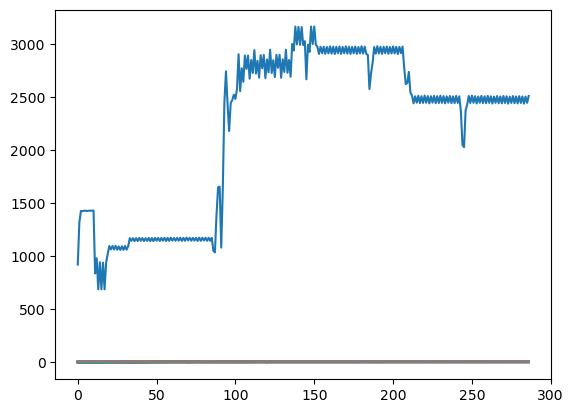

In [102]:
for i in range(38):
    plt.plot(x_199073[:, i])

In [48]:
signals = ['bmspinj', 'bmstinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 'ip', 'PCBCOIL', 'li_EFITRT2', 'aminor_EFITRT2', 
          'rmaxis_EFITRT2', 'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2']

prof_signals = ['Te', 'Ti', 'ne', 'Vtor', '1/q', 'p', 'j']
cake_normalizations = {}
for i, sig in enumerate(signals):
    cake_normalizations[sig] = {}
    cake_normalizations[sig]['mean'] = normalizations[0][0][i]
    cake_normalizations[sig]['std'] = normalizations[0][1][i]
for i, sig in enumerate(prof_signals):
    cake_normalizations[sig] = {}
    cake_normalizations[sig]['mean'] = normalizations[i+1][0]
    cake_normalizations[sig]['std'] = normalizations[i+1][1]
    cake_normalizations[sig]['pca_matrix'] = pca_components[2*i]
    cake_normalizations[sig]['pca_mean'] = pca_components[2*i+1]


In [84]:
prof_signals = ['thomson_temp_mtanh_1d', 'cer_temp_csaps_1d', 'thomson_density_mtanh_1d', 'rotation_kms', 'qpsi_EFITRT2', 'pres_EFITRT2']

signals = ['bmspinj', 'bmstinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 'ip', 'PCBCOIL', 'li_EFITRT2', 'aminor_EFITRT2', 
          'rmaxis_EFITRT2', 'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2']
with open('data/rt_pca_components_bms_pcb.pkl', 'rb') as f:
    pca_components = pickle.load(f)
with open('data/rt_normalizations_bms_pcb.pkl', 'rb') as f:
    normalizations = pickle.load(f)
with open('data/rt_pca_components_bms_pcb_rot.pkl', 'rb') as f:
    pca_components_rot = pickle.load(f)
with open('data/rt_normalizations_bms_pcb_rot.pkl', 'rb') as f:
    normalizations_rot = pickle.load(f)

rt_normalizations = {}
for i, sig in enumerate(signals):
    rt_normalizations[sig] = {}
    rt_normalizations[sig]['mean'] = normalizations[0][0][i]
    rt_normalizations[sig]['std'] = normalizations[0][1][i]
for i, sig in enumerate(prof_signals):
    rt_normalizations[sig] = {}
    rt_normalizations[sig]['mean'] = normalizations[i+1][0]
    rt_normalizations[sig]['std'] = normalizations[i+1][1]
    rt_normalizations[sig]['pca_matrix'] = pca_components[2*i]
    rt_normalizations[sig]['pca_mean'] = pca_components[2*i+1]

rt_normalizations['rotation_kms']['mean'] = normalizations_rot[0]
rt_normalizations['rotation_kms']['std'] = normalizations_rot[1]
rt_normalizations['rotation_kms']['pca_matrix'] = pca_components_rot[0]
rt_normalizations['rotation_kms']['pca_mean'] = pca_components_rot[1]

In [94]:
with open('data/rt_normalizations_dict.pkl', 'wb') as f:
    pickle.dump(rt_normalizations, f)

In [91]:
print(pca_components_rot[0])

[[-2.35081069e-01 -2.28682737e-01 -2.22284405e-01 -2.15886073e-01
  -2.09856721e-01 -2.03865540e-01 -1.97874358e-01 -1.92229630e-01
  -1.86664852e-01 -1.81100074e-01 -1.75857189e-01 -1.70740262e-01
  -1.65623335e-01 -1.60786246e-01 -1.56117059e-01 -1.51447871e-01
  -1.47008910e-01 -1.42773088e-01 -1.38537266e-01 -1.34478842e-01
  -1.30648500e-01 -1.26818158e-01 -1.23113901e-01 -1.19650350e-01
  -1.16186800e-01 -1.12805763e-01 -1.09672266e-01 -1.06538770e-01
  -1.03452066e-01 -1.00618043e-01 -9.77840203e-02 -9.49670759e-02
  -9.24063084e-02 -8.98455410e-02 -8.72847735e-02 -8.49680804e-02
  -8.26592607e-02 -8.03504410e-02 -7.82457639e-02 -7.61702500e-02
  -7.40947362e-02 -7.21867251e-02 -7.03256149e-02 -6.84645046e-02
  -6.67391854e-02 -6.50755893e-02 -6.34119932e-02 -6.18576171e-02
  -6.03779704e-02 -5.88983237e-02 -5.75061004e-02 -5.62013005e-02
  -5.48965006e-02 -5.36603215e-02 -5.25244342e-02 -5.13885470e-02
  -5.03031074e-02 -4.93286527e-02 -4.83541980e-02 -4.74122050e-02
  -4.65861

In [89]:
print(rt_normalizations['rotation_kms']['pca_matrix'])

[[-2.35081069e-01 -2.28682737e-01 -2.22284405e-01 -2.15886073e-01
  -2.09856721e-01 -2.03865540e-01 -1.97874358e-01 -1.92229630e-01
  -1.86664852e-01 -1.81100074e-01 -1.75857189e-01 -1.70740262e-01
  -1.65623335e-01 -1.60786246e-01 -1.56117059e-01 -1.51447871e-01
  -1.47008910e-01 -1.42773088e-01 -1.38537266e-01 -1.34478842e-01
  -1.30648500e-01 -1.26818158e-01 -1.23113901e-01 -1.19650350e-01
  -1.16186800e-01 -1.12805763e-01 -1.09672266e-01 -1.06538770e-01
  -1.03452066e-01 -1.00618043e-01 -9.77840203e-02 -9.49670759e-02
  -9.24063084e-02 -8.98455410e-02 -8.72847735e-02 -8.49680804e-02
  -8.26592607e-02 -8.03504410e-02 -7.82457639e-02 -7.61702500e-02
  -7.40947362e-02 -7.21867251e-02 -7.03256149e-02 -6.84645046e-02
  -6.67391854e-02 -6.50755893e-02 -6.34119932e-02 -6.18576171e-02
  -6.03779704e-02 -5.88983237e-02 -5.75061004e-02 -5.62013005e-02
  -5.48965006e-02 -5.36603215e-02 -5.25244342e-02 -5.13885470e-02
  -5.03031074e-02 -4.93286527e-02 -4.83541980e-02 -4.74122050e-02
  -4.65861

In [50]:
with open('data/cake_normalizations_dict.pkl', 'wb') as f:
    pickle.dump(cake_normalizations, f)

In [ ]:
### PCA tester

with open('data/rt_filtered_x_bms_pcb_rot.pkl', 'rb') as f:
    cake_raw = pickle.load(f)
with open('data/rt_x_pca_bms_pcb_rot.pkl', 'rb') as f:
    cake_pca = pickle.load(f)
with open('data/cakenn_filtered_pca_components_bms_pcb.pkl', 'rb') as f:
    pca_components = pickle.load(f)
with open('data/cakenn_filtered_normalizations_bms_pcb.pkl', 'rb') as f:
    normalizations = pickle.load(f)

x_train_df = filtered_data
# separate each normalized profile
scalars = x_train_df[:, 0:14]
j = x_train_df[:, 14:14+121]
ne = x_train_df[:, 14+121:14+121*2]
p = x_train_df[:, 14+121*2:14+121*3]
qinv = x_train_df[:, 14+121*3:14+121*4]
te = x_train_df[:, 14+121*4:14+121*5]
ti = x_train_df[:, 14+121*5:14+121*6]
vtor = x_train_df[:, 14+121*6:14+121*7]



# Fit PCA on the data
pca = PCA(n_components=4)
pca.components_ = pca_components[0][0]
pca.mean_ = pca_components[0][1]
j_pca = pca.transform(j)

pca = PCA(n_components=4)
pca.components_ = pca_components[1][0]
pca.mean_ = pca_components[1][1]
ne_pca = pca.transform(ne)


pca = PCA(n_components=4)
pca.components_ = pca_components[2][0]
pca.mean_ = pca_components[2][1]
p_pca = pca.transform(p)


pca = PCA(n_components=4)
pca.components_ = pca_components[3][0]
pca.mean_ = pca_components[3][1]
qinv_pca = pca.transform(qinv)

pca = PCA(n_components=4)
pca.components_ = pca_components[4][0]
pca.mean_ = pca_components[4][1]
te_pca = pca.transform(te)

pca = PCA(n_components=4)
pca.components_ = pca_components[5][0]
pca.mean_ = pca_components[5][1]
ti_pca = pca.transform(ti)


pca = PCA(n_components=4)
pca.components_ = pca_components[6][0]
pca.mean_ = pca_components[6][1]
vtor_pca = pca.transform(vtor)


# normalize PCA components

scalars_mean = normalizations[0][0]
scalars_std = normalizations[0][1]

scalars_normed = (scalars - scalars_mean)/scalars_std

j_pca_mean = normalizations[1][0]
j_pca_std = normalizations[1][1]
j_pca_normed = (j_pca - j_pca_mean)/j_pca_std

ne_pca_mean = normalizations[2][0]
ne_pca_std = normalizations[2][1]
ne_pca_normed = (ne_pca - ne_pca_mean)/ne_pca_std

p_pca_mean = normalizations[3][0]
p_pca_std = normalizations[3][1]
p_pca_normed = (p_pca - p_pca_mean)/p_pca_std

qinv_pca_mean = normalizations[4][0]
qinv_pca_std = normalizations[4][1]
qinv_pca_normed = (qinv_pca - qinv_pca_mean)/qinv_pca_std

te_pca_mean = normalizations[5][0]
te_pca_std = normalizations[5][1]
te_pca_normed = (te_pca - te_pca_mean)/te_pca_std

ti_pca_mean = normalizations[6][0]
ti_pca_std = normalizations[6][1]
ti_pca_normed = (ti_pca - ti_pca_mean)/ti_pca_std

vtor_pca_mean = normalizations[7][0]
vtor_pca_std = normalizations[7][1]
vtor_pca_normed = (vtor_pca - vtor_pca_mean)/vtor_pca_std

x_train_pca = pd.DataFrame(np.concatenate((scalars_normed, j_pca_normed, ne_pca_normed, p_pca_normed, qinv_pca_normed, te_pca_normed, ti_pca_normed, vtor_pca_normed), axis=1))


In [31]:
with h5.File('data/rtdata199073_199080.h5', 'r') as f:
    print(list(f['199074'].keys()))

['aminor_EFITRT1', 'aminor_EFITRT2', 'betan_EFITRT1', 'betan_EFITRT2', 'betanmax_sql', 'betap_EFITRT1', 'betap_EFITRT2', 'bmspinj', 'bmstinj', 'bt', 'btor_sql', 'btorsign_sql', 'cer_rot_csaps_1d', 'cer_rot_mtanh_1d', 'cer_rot_psi_raw_1d', 'cer_rot_r_raw_1d', 'cer_rot_raw_1d', 'cer_temp_csaps_1d', 'cer_temp_mtanh_1d', 'cer_temp_psi_raw_1d', 'cer_temp_r_raw_1d', 'cer_temp_raw_1d', 'drsep_EFITRT1', 'drsep_EFITRT2', 'gapbot_EFITRT1', 'gapbot_EFITRT2', 'gapin_EFITRT1', 'gapin_EFITRT2', 'gapout_EFITRT1', 'gapout_EFITRT2', 'gaptop_EFITRT1', 'gaptop_EFITRT2', 'ip', 'ip_flat_duration_sql', 'ip_sql', 'ipsign_sql', 'ipsiptargt', 'kappa_EFITRT1', 'kappa_EFITRT2', 'li_EFITRT1', 'li_EFITRT2', 'n1rms', 'nb_150_tilt', 'nb_210_rtan', 'nb_pinj', 'nb_tinj', 'nb_vinj', 'nb_vinj_scalar', 'pbeam_sql', 'pech_sql', 'pinj', 'poh_sql', 'pres_EFITRT1', 'pres_EFITRT2', 'psirz', 'psirz_r', 'psirz_z', 'q0_EFITRT1', 'q0_EFITRT2', 'q95_EFITRT1', 'q95_EFITRT2', 'qmin_EFITRT1', 'qmin_EFITRT2', 'qpsi_EFITRT1', 'qpsi_EFI

In [14]:
print(rt_x_pca_bms_pcb.shape)
print(e.shape)
print(t.shape)

(953707, 38)
(915363,)
(915363,)


In [13]:
model = SurvivalModel(model='dsm', 
                      iters=1, 
                      k=3, 
                      layers=[10,10], 
                      distribution='LogNormal',
                      learning_rate=1e-5, 
                      batch_size=1000
                    )

#_, train_loss, val_loss = model.fit(x_train_df, outcomes_train_df, val_data=(x_valid_df, outcomes_valid_df))
_, train_loss, val_loss = model.fit(pd.DataFrame(rt_x_pca_bms_pcb), outcomes_train_df)

IndexError: index 944040 is out of bounds for axis 0 with size 915363

In [6]:
combined_ip = h5.File('data/combined_ip.h5', 'r')
combined_bt = h5.File('data/combined_bt.h5', 'r')

In [18]:
with open('data_dict-2.pkl', 'rb') as f:
    data_dict_2 = pickle.load(f)

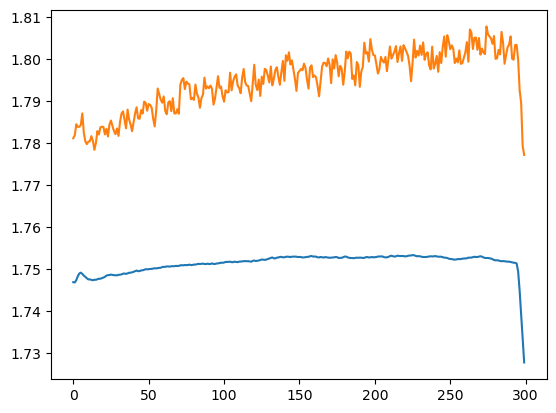

In [33]:
plt.plot(1.69861*0.00001*np.array(combined_bt['180636']['PCBCOIL']))
plt.plot(data_dict_2['180636']['bt'])
plt.plot()

<KeysViewHDF5 ['EFSIPMHD', 'IPMEAS_EFITRT2']>


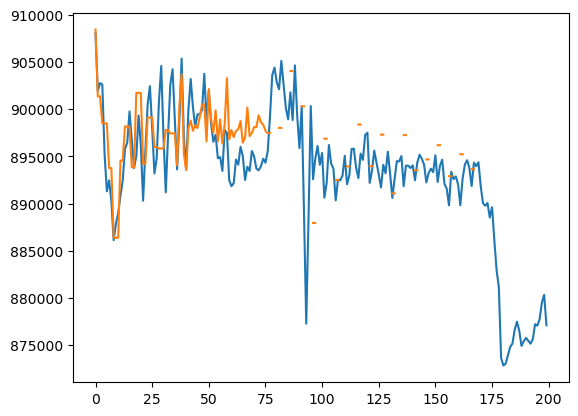

In [37]:
print(combined_ip['180636'].keys())
#plt.plot(list(combined_ip['199073']['EFSIPMHD']))
plt.plot(data_dict_2['180635']['ip'][100:])
plt.plot(list(combined_ip['180635']['IPMEAS_EFITRT2'][100:]))

In [3]:
#profiles = ['j', 'ne', 'p', 'qinv', 'Te', 'Ti', 'Vtor']
profiles = ['Te', 'Ti', 'ne', 'Vtor', 'qinv', 'p', 'j']

In [103]:
with open('data/rotation.pkl', 'rb') as f:
    rotation = pickle.load(f)
print(rotation.keys())

dict_keys(['180504', '180505', '180507', '180510', '180514', '180515', '180516', '180517', '180519', '180520', '180523', '180524', '180526', '180527', '180528', '180529', '180530', '180531', '180533', '180536', '180537', '180538', '180540', '180541', '180542', '180543', '180544', '180545', '180548', '180549', '180584', '180585', '180590', '180591', '180592', '180593', '180599', '180600', '180601', '180602', '180603', '180604', '180605', '180606', '180607', '180612', '180613', '180614', '180615', '180616', '180617', '180619', '180620', '180621', '180622', '180623', '180624', '180625', '180626', '180628', '180629', '180630', '180631', '180632', '180633', '180634', '180635', '180636', '180637', '180638', '180640', '180641', '180642', '180643', '180644', '180645', '180646', '180647', '180653', '180654', '180655', '180656', '180657', '180658', '180659', '180660', '180661', '180663', '180664', '180665', '180666', '180667', '180668', '180669', '180670', '180671', '180672', '180673', '180674',

In [8]:
# add bmspinj, bmstinj to data_dict-2 dataset
extra_signals = ['bmspinj', 'bmstinj']
extra_signals_2 = ['PCBCOIL']
extra_signals_3 = ['rotation_kms']
with open('data/bms_dict.pkl', 'rb') as f:
    data_dict = pickle.load(f)
with open('data_dict-2.pkl', 'rb') as f:
    data_dict_2 = pickle.load(f)
combined_bt = h5.File('data/combined_bt.h5', 'r')
with open('data/rotation.pkl', 'rb') as f:
    rotation = pickle.load(f)
def rename_key(data, old_key, new_key):
    for shot in data:
        if old_key in data[shot]:
            data[shot][new_key] = data[shot].pop(old_key)
# Rename the key
rename_key(rotation, 'cer_rot_csaps_1d', 'rotation_kms')

data_dict_3 = {}
for shot in sorted(set(data_dict.keys()).intersection(data_dict_2.keys())):
    data_dict_3[shot] = data_dict_2[shot]
    for signal in extra_signals:
        if shot in data_dict.keys():
            if signal in data_dict[shot].keys():
                data_dict_3[shot][signal] = data_dict[shot][signal]
data_dict_4 = {}
for shot in sorted(set(data_dict_3.keys()).intersection(list(combined_bt.keys()))):
    data_dict_4[shot] = data_dict_3[shot]
    for signal in extra_signals_2:
        if signal in list(combined_bt[shot].keys()):
            data_dict_4[shot][signal] = 1.69861*0.00001*np.array(combined_bt[shot][signal])
data_dict_5 = {}
for shot in sorted(set(data_dict_4.keys()).intersection(list(rotation.keys()))):
    data_dict_5[shot] = data_dict_4[shot]
    for signal in extra_signals_3:
        if signal in list(rotation[shot].keys()):
            data_dict_5[shot][signal] = np.array(rotation[shot][signal])


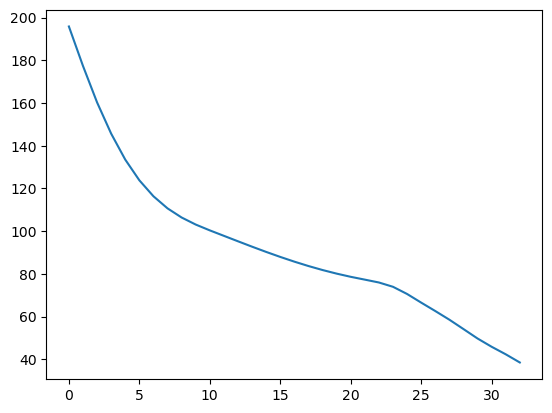

In [70]:
plt.plot(data_dict_5['180636']['rotation_kms'][30])

PROCESS CAKENN DATABASE

In [9]:
#profiles = ['j', 'ne', 'p', 'qinv', 'Te', 'Ti', 'Vtor']
#rofiles = ['Te', 'Ti', 'ne', 'Vtor', 'qinv', 'p', 'j']
true_labels = ['p [kPa]', '1/q', r'j [MA m$^{-2}$]', r'n$_e$ [10$^{19}$ m$^{-3}$]', r'T$_e$ [keV]', r'T$_i$ [keV]', r'V$_{tor}$ [km/s]']
profiles = ['p', '1/q', 'j', 'ne', 'Te', 'Ti', 'Vtor']
with open('data/cakenn_combined.pkl', 'rb') as f:
    cakenn_combined = pickle.load(f)

def convert_dict(original_dict, profiles):
    new_dict = {}
    times_dict = {}
    for shot, time_dict in original_dict.items():
        # Initialize new dictionary for the current shot
        new_dict[shot] = {profile: [] for profile in profiles}
        times_dict[shot] = list(time_dict.keys())
        for time, data in time_dict.items():
            for i, profile in enumerate(profiles):
                new_dict[shot][profile].append(data[0][:, i])
        
        # Convert lists to numpy arrays
        for profile in profiles:
            new_dict[shot][profile] = np.array(new_dict[shot][profile])
    
    return new_dict, times_dict

new_dict, times_dict = convert_dict(cakenn_combined, profiles)

In [10]:
signals = ['bmspinj', 'bmstinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 'ip', 'PCBCOIL', 'li_EFITRT2', 'aminor_EFITRT2', 
          'rmaxis_EFITRT2', 'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2', 't_ip_flat_sql', 'ip_flat_duration_sql']

#prof_signals = ['j', 'ne', 'p', 'qinv', 'Te', 'Ti', 'Vtor']
prof_signals = ['Te', 'Ti', 'ne', 'Vtor', '1/q', 'p', 'j']
# first I need to remove all profiles from data_dict-2, and replace them with cakenn profiles

'''with open('data_dict-2.pkl', 'rb') as f:
    data = pickle.load(f)'''
data = data_dict_4
# this shot has messed up datastructure
del data['192209']
shots = list(data.keys())
print(data[shots[0]].keys())

final_dict = {}
for shot, shot_data in data.items():
    if shot in new_dict.keys():
        final_dict[shot] = {}
        for signal in signals:
            final_dict[shot][signal] = shot_data[signal]
        for profile in new_dict[shot].keys():
            final_dict[shot][profile] = new_dict[shot][profile]

dict_keys(['pinj', 'tinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 'ip', 'bt', 'li_EFITRT2', 'aminor_EFITRT2', 'rmaxis_EFITRT2', 'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2', 't_ip_flat_sql', 'ip_flat_duration_sql', 'thomson_temp_mtanh_1d', 'cer_temp_csaps_1d', 'thomson_density_mtanh_1d', 'cer_rot_csaps_1d', 'qpsi_EFITRT2', 'pres_EFITRT2', 'bmspinj', 'bmstinj', 'PCBCOIL', 'rotation_kms'])


In [11]:
# add zeros to fill cakenn profiles
times = np.arange(0, 6000, 20)
for shot, shot_data in final_dict.items():
    cakenn_time_start = times_dict[shot][0]
    cakenn_time_end = times_dict[shot][-1]
    cakenn_time_start_index = np.where(times == int(cakenn_time_start))[0][0]
    if int(cakenn_time_end) < 6000:
        cakenn_time_end_index = np.where(times == int(cakenn_time_end))[0][0]
        for profile in prof_signals:
            temp_data = np.zeros((len(times), 121))
            temp_data[cakenn_time_start_index:cakenn_time_end_index+1, :] = shot_data[profile]
            shot_data[profile] = temp_data
    else:
        cakenn_time_end_index = np.where(times == 5980)[0][0]
        index_where_cakenn_excedes_6000 = np.where(np.array(times_dict[shot]) == '6000')[0][0]
        for profile in prof_signals:
            temp_data = np.zeros((len(times), 121))
            temp_data[cakenn_time_start_index:cakenn_time_end_index+1, :] = shot_data[profile][:index_where_cakenn_excedes_6000, :]
            shot_data[profile] = temp_data

In [12]:

#database = h5.File('/projects/EKOLEMEN/profile_predictor/joe_hiro_models/diiid_data.h5', 'r')
tm_data = h5.File('/projects/EKOLEMEN/survival_tm/tm_labels.h5', 'r')

final_scalars = ['bmspinj', 'bmstinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 'ip', 'PCBCOIL', 'li_EFITRT2', 'aminor_EFITRT2', 
          'rmaxis_EFITRT2', 'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2']

data = final_dict

def check_all_signals(shot_data, prof_signals, signals, ind):
    # Check scalars for nan values
    for sig in signals:
        if np.isnan(shot_data[sig][ind]):
            return False
    
    # Check profiles for nan values
    for sig in prof_signals:
        if np.sum(np.isnan(shot_data[sig][ind,:])) > 0:
            return False
       
    return True

def gather_feature(shot_data, prof_signals, signals, ind):
    feature = np.zeros(len(prof_signals)*121+len(signals))
    
    # Load scalar signals
    for i, sig in enumerate(signals):
        feature[i] = shot_data[sig][ind]
    
    # Load profile signals
    for i, sig in enumerate(prof_signals):
        feature[121*i+len(signals):121*(i+1)+len(signals)] = shot_data[sig][ind,:]
    
    return feature

x = []
t = []
e = []
shots_rt = []
times = np.arange(0, 6000, 20)[::-1]
# I should check the timesteps are the same for all scalars
for shot in shots:
    if shot in list(tm_data.keys()) and shot in list(data.keys()):
        # First figure out time of TM, or time of end of shot
        label = tm_data[shot]['label'][:]
        time = tm_data[shot]['time'][:]
        tm_ind = np.argmax(label>0)
        tm_time = time[tm_ind]
        # Find start and stop of flattop
        start = np.array(data[shot]['t_ip_flat_sql'])
        duration = np.array(data[shot]['ip_flat_duration_sql'])
        stop = start+duration
        # Get start and stop inds
        start_ind = np.argmin(np.abs(time - start))
        end_ind = np.argmin(np.abs(time - stop))
        
        # End shot when TM occurs
        if end_ind > tm_ind and tm_ind > 0:
            end_ind = tm_ind
        
        # Go through valid indices and gather dataset
        for ind in range(start_ind, end_ind):
            # Check that we have all signals at this time
            if check_all_signals(data[shot], prof_signals, final_scalars, ind):
                feature = gather_feature(data[shot], prof_signals, final_scalars, ind)
                x.append(feature)
                if tm_time > 0:
                    # Time to TM
                    t.append(tm_time - time[ind])
                    shots_rt.append(shot)
                    e.append(1)
                else:
                    # Time to end of shot
                    t.append(time[end_ind] - time[ind])
                    shots_rt.append(shot)
                    e.append(0)


In [38]:
print(std_dev)

[2.64363564e+00 2.20481791e+00 1.00000000e+00 8.05022725e-01
 1.17496369e+06 6.22111005e+05 1.80803690e+00 1.00000000e+00
 2.03931361e-02 3.89291141e-02 2.72184104e-01 2.68118880e-01
 9.57802306e-02 9.95729265e-01 9.85355522e-01 9.88481685e-01
 9.72474667e-01 9.62688356e-01 9.44657484e-01 9.32197945e-01
 9.21303646e-01 9.12097927e-01 9.01121187e-01 8.92844019e-01
 8.81804958e-01 8.71436614e-01 8.61680170e-01 8.51189849e-01
 8.39684610e-01 8.28544153e-01 8.17504801e-01 8.08114870e-01
 7.99035123e-01 7.90418618e-01 7.81633271e-01 7.73626926e-01
 7.65415209e-01 7.56998149e-01 7.47818670e-01 7.38641655e-01
 7.28333103e-01 7.18923572e-01 7.10530177e-01 7.03394701e-01
 6.95569769e-01 6.88800192e-01 6.81119566e-01 6.73961406e-01
 6.65906529e-01 6.58249838e-01 6.52041992e-01 6.45403322e-01
 6.38277394e-01 6.33013586e-01 6.27563932e-01 6.22433421e-01
 6.14300364e-01 6.08565943e-01 6.01328457e-01 5.95860901e-01
 5.89341349e-01 5.84216009e-01 5.78650613e-01 5.74243711e-01
 5.66496538e-01 5.611121

In [13]:
data = np.copy(x)
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)
mean[2] = 0
std_dev[2] = 1
mean[7] = 0
std_dev[7] = 1

# Define the threshold for filtering
threshold = 8*std_dev

# Identify rows with any values that are more than 10 standard deviations away from the mean for any column
rows_with_anomalies = np.any(np.abs(data - mean) > threshold, axis=1)

# Filter out the rows with anomalies
filtered_data = data[~rows_with_anomalies]

In [5]:
with open('data/cakenn_filtered_x_bms_pcb.pkl', 'wb') as f:
    pickle.dump(filtered_data, f)
with open('data/cakenn_filtered_t_bms_pcb.pkl', 'wb') as f:
    pickle.dump(np.array(t)[~rows_with_anomalies], f)
with open('data/cakenn_filtered_e_bms_pcb.pkl', 'wb') as f:
    pickle.dump(np.array(e)[~rows_with_anomalies], f)
with open('data/cakenn_filtered_shots_pcb.pkl', 'wb') as f:
    pickle.dump(np.array(shots_rt)[~rows_with_anomalies], f)

NameError: name 'filtered_data' is not defined

In [6]:
with open('data/cakenn_filtered_x_bms_pcb.pkl', 'rb') as f:
    x = pickle.load(f)


EOFError: Ran out of input

CAKENN PREPROCESS

In [15]:
with open('data/rt_normalizations_bms_pcb.pkl', 'rb') as f:
    normalizations = pickle.load(f)

print(normalizations[0][1])

[2.66759155e+00 2.19227709e+00 7.19319450e-01 7.70894598e-01
 1.16621825e+06 6.09874895e+05 1.78458681e+00 2.02886809e-01
 2.03017997e-02 3.78955854e-02 2.72418598e-01 2.65364688e-01
 9.10486014e-02 9.95019534e-01]


In [65]:
'''with open('data/cakenn_x_bms_pcb.pkl', 'rb') as f:
    x_train_df = np.array(pickle.load(f))'''
x_train_df = filtered_data
# separate each normalized profile
scalars = x_train_df[:, 0:14]
j = x_train_df[:, 14:14+121]
ne = x_train_df[:, 14+121:14+121*2]
p = x_train_df[:, 14+121*2:14+121*3]
qinv = x_train_df[:, 14+121*3:14+121*4]
te = x_train_df[:, 14+121*4:14+121*5]
ti = x_train_df[:, 14+121*5:14+121*6]
vtor = x_train_df[:, 14+121*6:14+121*7]

pca_components = []
# Fit PCA on the data
pca = PCA(n_components=4)
pca.fit(j)
j_pca = pca.transform(j)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)

pca = PCA(n_components=4)
pca.fit(ne)
ne_pca = pca.transform(ne)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)

pca = PCA(n_components=4)
pca.fit(p)
p_pca = pca.transform(p)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)

pca = PCA(n_components=4)
pca.fit(qinv)
qinv_pca = pca.transform(qinv)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)

pca = PCA(n_components=4)
pca.fit(te)
te_pca = pca.transform(te)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)

pca = PCA(n_components=4)
pca.fit(ti)
ti_pca = pca.transform(ti)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)

pca = PCA(n_components=4)
pca.fit(vtor)
vtor_pca = pca.transform(vtor)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)

# normalize PCA components

scalars_mean = np.mean(scalars, axis=0)
scalars_std = np.std(scalars, axis=0)
print(scalars_mean)
print(scalars_std)
scalars_mean = normalizations[0][0]
scalars_std = normalizations[0][1]
print(scalars_mean)
print(scalars_std)

scalars_normed = (scalars - scalars_mean)/scalars_std

j_pca_mean = np.mean(j_pca)
j_pca_std = np.std(j_pca)
j_pca_normed = (j_pca - j_pca_mean)/j_pca_std

ne_pca_mean = np.mean(ne_pca)
ne_pca_std = np.std(ne_pca)
ne_pca_normed = (ne_pca - ne_pca_mean)/ne_pca_std

p_pca_mean = np.mean(p_pca)
p_pca_std = np.std(p_pca)
p_pca_normed = (p_pca - p_pca_mean)/p_pca_std

qinv_pca_mean = np.mean(qinv_pca)
qinv_pca_std = np.std(qinv_pca)
qinv_pca_normed = (qinv_pca - qinv_pca_mean)/qinv_pca_std

te_pca_mean = np.mean(te_pca)
te_pca_std = np.std(te_pca)
te_pca_normed = (te_pca - te_pca_mean)/te_pca_std

ti_pca_mean = np.mean(ti_pca)
ti_pca_std = np.std(ti_pca)
ti_pca_normed = (ti_pca - ti_pca_mean)/ti_pca_std

vtor_pca_mean = np.mean(vtor_pca)
vtor_pca_std = np.std(vtor_pca)
vtor_pca_normed = (vtor_pca - vtor_pca_mean)/vtor_pca_std

normalizations = [(scalars_mean, scalars_std), (j_pca_mean, j_pca_std), (ne_pca_mean, ne_pca_std), (p_pca_mean, p_pca_std), (qinv_pca_mean, qinv_pca_std), (te_pca_mean, te_pca_std), (ti_pca_mean, ti_pca_std), (vtor_pca_mean, vtor_pca_std)]
x_train_pca = pd.DataFrame(np.concatenate((scalars_normed, j_pca_normed, ne_pca_normed, p_pca_normed, qinv_pca_normed, te_pca_normed, ti_pca_normed, vtor_pca_normed), axis=1))
with open('data/cakenn__filtered_x_pca_bms_pcb.pkl', 'wb') as f:
    pickle.dump(x_train_pca, f)

with open('data/cakenn_filtered_normalizations_bms_pcb.pkl', 'wb') as f:
    pickle.dump(normalizations, f)

with open('data/cakenn_filtered_pca_components_bms_pcb.pkl', 'wb') as f:
    pickle.dump(pca_components, f)

/tmp/ipykernel_4032846/3740240538.py:12: RuntimeWarning: divide by zero encountered in divide
  ti = 1/ti


KeyboardInterrupt: 

FROM TM LABELS AND DATABASE, CREATE X, T, E, SHOTS

In [39]:
print(x_train_pca.shape)

(677494, 42)


In [71]:
def check_all_signals(shot_data, prof_signals, signals, ind):
    # Check scalars for nan values
    for sig in signals:
        if np.isnan(shot_data[sig][ind]):
            return False
    
    # Check profiles for nan values
    for sig in prof_signals:
        if np.sum(np.isnan(shot_data[sig][ind,:])) > 0:
            return False
       
    return True

def gather_feature(shot_data, prof_signals, signals, ind):
    feature = np.zeros(len(prof_signals)*33+len(signals))
    
    # Load scalar signals
    for i, sig in enumerate(signals):
        feature[i] = shot_data[sig][ind]
    
    # Load profile signals
    for i, sig in enumerate(prof_signals):
        feature[33*i+len(signals):33*(i+1)+len(signals)] = shot_data[sig][ind,:]
    
    return feature

In [72]:
tm_data = h5.File('/projects/EKOLEMEN/survival_tm/tm_labels.h5', 'r')

signals = ['bmspinj', 'bmstinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 'ip', 'PCBCOIL', 'li_EFITRT2', 'aminor_EFITRT2', 
          'rmaxis_EFITRT2', 'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2']

#prof_signals = ['thomson_temp_mtanh_1d', 'cer_temp_csaps_1d', 'thomson_density_mtanh_1d', 'cer_rot_csaps_1d', 'qpsi_EFITRT2', 'pres_EFITRT2']
prof_signals = ['thomson_temp_mtanh_1d', 'cer_temp_csaps_1d', 'thomson_density_mtanh_1d', 'rotation_kms', 'qpsi_EFITRT2', 'pres_EFITRT2']

'''with open('data_dict-2.pkl', 'rb') as f:
    data = pickle.load(f)'''
# this shot has messed up datastructure
data = data_dict_5
del data['192209']
shots = list(data.keys())
print(data[shots[0]].keys())

x = []
t = []
e = []
shots_rt = []
times = np.arange(0, 6000, 20)[::-1]
# I should check the timesteps are the same for all scalars
for shot in shots:
    if shot in list(tm_data.keys()):
        # First figure out time of TM, or time of end of shot
        label = tm_data[shot]['label'][:]
        time = tm_data[shot]['time'][:]
        tm_ind = np.argmax(label>0)
        tm_time = time[tm_ind]
        # Find start and stop of flattop
        start = np.array(data[shot]['t_ip_flat_sql'])
        duration = np.array(data[shot]['ip_flat_duration_sql'])
        stop = start+duration
        # Get start and stop inds
        start_ind = np.argmin(np.abs(time - start))
        end_ind = np.argmin(np.abs(time - stop))
        
        # End shot when TM occurs
        if end_ind > tm_ind and tm_ind > 0:
            end_ind = tm_ind
        
        # Go through valid indices and gather dataset
        for ind in range(start_ind, end_ind):
            # Check that we have all signals at this time
            if check_all_signals(data[shot], prof_signals, signals, ind):
                feature = gather_feature(data[shot], prof_signals, signals, ind)
                x.append(feature)
                if tm_time > 0:
                    # Time to TM
                    t.append(tm_time - time[ind])
                    shots_rt.append(shot)
                    e.append(1)
                else:
                    # Time to end of shot
                    t.append(time[end_ind] - time[ind])
                    shots_rt.append(shot)
                    e.append(0)

dict_keys(['pinj', 'tinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 'ip', 'bt', 'li_EFITRT2', 'aminor_EFITRT2', 'rmaxis_EFITRT2', 'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2', 't_ip_flat_sql', 'ip_flat_duration_sql', 'thomson_temp_mtanh_1d', 'cer_temp_csaps_1d', 'thomson_density_mtanh_1d', 'cer_rot_csaps_1d', 'qpsi_EFITRT2', 'pres_EFITRT2', 'bmspinj', 'bmstinj', 'PCBCOIL', 'rotation_kms'])


In [73]:
data = np.copy(x)
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)
mean[2] = 0
std_dev[2] = 1
mean[7] = 0
std_dev[7] = 1

# Define the threshold for filtering
threshold = 8*std_dev
data[:, 14+33*4:14+33*5] = 1/data[:, 14+33*4:14+33*5]
# Identify rows with any values that are more than 10 standard deviations away from the mean for any column
rows_with_anomalies = np.any(np.abs(data - mean) > threshold, axis=1)
data[:, 14+33*4:14+33*5] = 1/data[:, 14+33*4:14+33*5]
# Filter out the rows with anomalies
filtered_data = data[~rows_with_anomalies]

with open('data/rt_filtered_x_bms_pcb_rot.pkl', 'wb') as f:
    pickle.dump(filtered_data, f)
with open('data/rt_filtered_t_bms_pcb_rot.pkl', 'wb') as f:
    pickle.dump(np.array(t)[~rows_with_anomalies], f)
with open('data/rt_filtered_e_bms_pcb_rot.pkl', 'wb') as f:
    pickle.dump(np.array(e)[~rows_with_anomalies], f)
with open('data/rt_filtered_shots_pcb_rot.pkl', 'wb') as f:
    pickle.dump(np.array(shots_rt)[~rows_with_anomalies], f)

/tmp/ipykernel_2719598/694181330.py:11: RuntimeWarning: divide by zero encountered in divide
  data[:, 14+33*4:14+33*5] = 1/data[:, 14+33*4:14+33*5]


CREATE MAIN PREPROCESSED DATABASE

CREATE PCA DATABASE

In [19]:
with open('data/rt_filtered_x_bms_pcb_rot.pkl', 'rb') as f:
    x_train_df = pickle.load(f)
'''
with open('data/x_valid_df1.pkl', 'rb') as f:
    x_valid_df = pickle.load(f)
with open('data/outcomes_train_df1.pkl', 'rb') as f:
    outcomes_train_df = pickle.load(f)
with open('data/outcomes_valid_df1.pkl', 'rb') as f:
    outcomes_valid_df = pickle.load(f)'''

'''with open('data/rt_filtered_x.pkl', 'rb') as f:
    x_train_df = pickle.load(f)'''

# separate each normalized profile
scalars = np.array(x_train_df)[:, 0:14]
te = np.array(x_train_df)[:, 14:33+14]
ti = np.array(x_train_df)[:, 33+14:66+14]
ne = np.array(x_train_df)[:, 66+14:99+14]
rot = np.array(x_train_df)[:, 99+14:132+14]
qpsi = np.array(x_train_df)[:, 132+14:165+14]
qpsi = 1/qpsi
qpsi = np.where(qpsi == np.inf, 1, qpsi)
pres = np.array(x_train_df)[:, 165+14:198+14]

'''scalars_temp = np.array(x_199073_joint)[:, :14]
te_temp = np.array(x_199073_joint)[:, 14:33+14]
ti_temp = np.array(x_199073_joint)[:, 33+14:66+14]
ne_temp = np.array(x_199073_joint)[:, 66+14:99+14]
rot_temp = np.array(x_199073_joint)[:, 99+14:132+14]
qpsi_temp = np.array(x_199073_joint)[:, 132+14:165+14]
qpsi_temp = 1/qpsi_temp
qpsi_temp = np.where(qpsi_temp == np.inf, 1, qpsi_temp)
pres_temp = np.array(x_199073_joint)[:, 165+14:198+14]'''

# upsample to PCS dimensions
x_old = np.linspace(0, 1, 33)
x_long = np.linspace(0, 1, 100)
x_for_q = np.linspace(0, 1, 65)
te = np.array([np.interp(x_long, x_old, te[i]) for i in range(len(te))])
ti = np.array([np.interp(x_long, x_old, ti[i]) for i in range(len(ti))])
ne = np.array([np.interp(x_long, x_old, ne[i]) for i in range(len(ne))])
rot = np.array([np.interp(x_long, x_old, rot[i]) for i in range(len(rot))])
qpsi = np.array([np.interp(x_for_q, x_old, qpsi[i]) for i in range(len(qpsi))])
pres = np.array([np.interp(x_for_q, x_old, pres[i]) for i in range(len(pres))])

'''te_temp = np.array([np.interp(x_long, x_old, te_temp[i]) for i in range(len(te_temp))])
ti_temp = np.array([np.interp(x_long, x_old, ti_temp[i]) for i in range(len(ti_temp))])
ne_temp = np.array([np.interp(x_long, x_old, ne_temp[i]) for i in range(len(ne_temp))])
rot_temp = np.array([np.interp(x_long, x_old, rot_temp[i]) for i in range(len(rot_temp))])
qpsi_temp = np.array([np.interp(x_for_q, x_old, qpsi_temp[i]) for i in range(len(qpsi_temp))])
pres_temp = np.array([np.interp(x_for_q, x_old, pres_temp[i]) for i in range(len(pres_temp))])'''

pca_components = []
# Fit PCA on the data
pca = PCA(n_components=4)
pca.fit(te)
te_pca = pca.transform(te)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)
#te_temp_pca = pca.transform(te_temp)

pca = PCA(n_components=4)
pca.fit(ti)
ti_pca = pca.transform(ti)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)
#ti_temp_pca = pca.transform(ti_temp)

pca = PCA(n_components=4)
pca.fit(ne)
ne_pca = pca.transform(ne)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)
#ne_temp_pca = pca.transform(ne_temp)

pca = PCA(n_components=4)
pca.fit(rot)
rot_pca = pca.transform(rot)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)
#rot_temp_pca = pca.transform(rot_temp)

pca = PCA(n_components=4)
pca.fit(qpsi)
qpsi_pca = pca.transform(qpsi)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)
#qpsi_temp_pca = pca.transform(qpsi_temp)

pca = PCA(n_components=4)
pca.fit(pres)
pres_pca = pca.transform(pres)
pca_components.append(pca.components_)
pca_components.append(pca.mean_)
#pres_temp_pca = pca.transform(pres_temp)
# normalize PCA components

scalars_mean = np.mean(scalars, axis=0)
scalars_std = np.std(scalars, axis=0)
scalars_normed = (scalars - scalars_mean)/scalars_std
#scalars_temp_normed = (scalars_temp - scalars_mean)/scalars_std

te_pca_mean = np.mean(te_pca)
te_pca_std = np.std(te_pca)
te_pca_normed = (te_pca - te_pca_mean)/te_pca_std
#te_temp_pca_normed = (te_temp_pca - te_pca_mean)/te_pca_std

ti_pca_mean = np.mean(ti_pca)
ti_pca_std = np.std(ti_pca)
ti_pca_normed = (ti_pca - ti_pca_mean)/ti_pca_std
#ti_temp_pca_normed = (ti_temp_pca - ti_pca_mean)/ti_pca_std

ne_pca_mean = np.mean(ne_pca)
ne_pca_std = np.std(ne_pca)
ne_pca_normed = (ne_pca - ne_pca_mean)/ne_pca_std
#ne_temp_pca_normed = (ne_temp_pca - ne_pca_mean)/ne_pca_std

rot_pca_mean = np.mean(rot_pca)
rot_pca_std = np.std(rot_pca)
rot_pca_normed = (rot_pca - rot_pca_mean)/rot_pca_std
#rot_temp_pca_normed = (rot_temp_pca - rot_pca_mean)/rot_pca_std

qpsi_pca_mean = np.mean(qpsi_pca)
qpsi_pca_std = np.std(qpsi_pca)
qpsi_pca_normed = (qpsi_pca - qpsi_pca_mean)/qpsi_pca_std
#qpsi_temp_pca_normed = (qpsi_temp_pca - qpsi_pca_mean)/qpsi_pca_std

pres_pca_mean = np.mean(pres_pca)
pres_pca_std = np.std(pres_pca)
pres_pca_normed = (pres_pca - pres_pca_mean)/pres_pca_std
#pres_temp_pca_normed = (pres_temp_pca - pres_pca_mean)/pres_pca_std
print(scalars_mean[0],scalars_std[0])
normalizations = [(scalars_mean, scalars_std), (te_pca_mean, te_pca_std), (ti_pca_mean, ti_pca_std), (ne_pca_mean, ne_pca_std), (rot_pca_mean, rot_pca_std), (qpsi_pca_mean, qpsi_pca_std), (pres_pca_mean, pres_pca_std)]

x_train_pca = pd.DataFrame(np.concatenate((scalars_normed, te_pca_normed, ti_pca_normed, ne_pca_normed, rot_pca_normed, qpsi_pca_normed, pres_pca_normed), axis=1))
#x_temp_pca = pd.DataFrame(np.concatenate((scalars_temp_normed, te_temp_pca_normed, ti_temp_pca_normed, ne_temp_pca_normed, rot_temp_pca_normed, qpsi_temp_pca_normed), axis=1))
'''with open('data/x_temp_pca.pkl', 'wb') as f:
    pickle.dump(x_temp_pca, f)'''


with open('data/rt_x_pca_bms_pcb.pkl', 'wb') as f:
    pickle.dump(x_train_pca, f)

with open('data/rt_normalizations_bms_pcb.pkl', 'wb') as f:
    pickle.dump(normalizations, f)

with open('data/rt_pca_components_bms_pcb.pkl', 'wb') as f:
    pickle.dump(pca_components, f)

5.482950287257639 2.667591547466661


In [120]:
with open('data/x_temp_pca.pkl', 'wb') as f:
    pickle.dump(x_temp_pca, f)

In [5]:
def find_peaks_in_data(data):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i-1] < data[i] > data[i+1]:
            peaks.append(i)
    return peaks

CREATE MEMORY DATABASE

In [6]:
# we give each timestep all the info from a few timesteps in the past. 

x_train_np = np.array(x_train)
t_train_np = np.array(t_train)[4:]
e_train_np = np.array(e_train)[4:]

x_valid_np = np.array(x_valid)
t_valid_np = np.array(t_valid)[4:]
e_valid_np = np.array(e_valid)[4:]

x_test_np = np.array(x_test)
t_test_np = np.array(t_test)[4:]
e_test_np = np.array(e_test)[4:]

outcomes_valid_memory = pd.DataFrame({'time': t_valid_np, 'event': e_valid_np})
outcomes_test_memory = pd.DataFrame({'time': t_test_np, 'event': e_test_np})
outcomes_train_memory = pd.DataFrame({'time': t_train_np, 'event': e_train_np})

# make the state of each timestep contain 5 timesteps of data
x_valid_memory = np.array([x_valid_np[i-4:i+1].flatten() for i in range(4, len(x_valid_np))])
x_test_memory = np.array([x_test_np[i-4:i+1].flatten() for i in range(4, len(x_test_np))])
x_train_memory = np.array([x_train_np[i-4:i+1].flatten() for i in range(4, len(x_train_np))])

# remove the first 4 timesteps of each shot from the dataset. This is so that data from the previous shot isn't saved in the current shot
train_peaks = np.array(find_peaks_in_data(np.array(outcomes_train_memory['time'])))
valid_peaks = np.array(find_peaks_in_data(np.array(outcomes_valid_memory['time'])))
test_peaks = np.array(find_peaks_in_data(np.array(outcomes_test_memory['time'])))
new_train_peaks = np.sort(np.concatenate((train_peaks, train_peaks+1, train_peaks+2, train_peaks+3)))
new_valid_peaks = np.sort(np.concatenate((valid_peaks, valid_peaks+1, valid_peaks+2, valid_peaks+3)))
new_test_peaks = np.sort(np.concatenate((test_peaks, test_peaks+1, test_peaks+2, test_peaks+3)))
x_valid_memory = pd.DataFrame(np.delete(x_valid_memory, new_valid_peaks, axis=0))
x_test_memory = pd.DataFrame(np.delete(x_test_memory, new_test_peaks, axis=0))
x_train_memory = pd.DataFrame(np.delete(x_train_memory, new_train_peaks, axis=0))

# normalize
scaler = Scaler()
transformer = scaler.fit(x_train_memory)
x_train_memory_normed = transformer.transform(x_train_memory)
x_valid_memory_normed = transformer.transform(x_valid_memory)
x_test_memory_normed = transformer.transform(x_test_memory)

'''with open('data/x_valid_memory_normed.pkl', 'wb') as f:
    pickle.dump(x_valid_memory_normed, f)
with open('data/x_test_memory_normed.pkl', 'wb') as f:
    pickle.dump(x_test_memory_normed, f)
with open('data/x_train_memory_normed.pkl', 'wb') as f:
    pickle.dump(x_train_memory_normed, f)
with open('data/outcomes_valid_memory.pkl', 'wb') as f:
    pickle.dump(outcomes_valid_memory, f)
with open('data/outcomes_train_memory.pkl', 'wb') as f:
    pickle.dump(outcomes_train_memory, f)
with open('data/outcomes_test_memory.pkl', 'wb') as f:
    pickle.dump(outcomes_test_memory, f)'''

"with open('data/x_valid_memory_normed.pkl', 'wb') as f:\n    pickle.dump(x_valid_memory_normed, f)\nwith open('data/x_test_memory_normed.pkl', 'wb') as f:\n    pickle.dump(x_test_memory_normed, f)\nwith open('data/x_train_memory_normed.pkl', 'wb') as f:\n    pickle.dump(x_train_memory_normed, f)\nwith open('data/outcomes_valid_memory.pkl', 'wb') as f:\n    pickle.dump(outcomes_valid_memory, f)\nwith open('data/outcomes_train_memory.pkl', 'wb') as f:\n    pickle.dump(outcomes_train_memory, f)\nwith open('data/outcomes_test_memory.pkl', 'wb') as f:\n    pickle.dump(outcomes_test_memory, f)"

CREATE FUTURE ACTUATORS DATABASE. SAME LOGIC AS ABOVE, BUT ONLY SAVING SCALARS DATA

In [7]:
signals = ['pinj', 'tinj', 'betan_EFIT01', 'qmin_EFIT01', 'ech_pwr_total', 'ip', 'bt', 'li_EFIT01', 'aminor_EFIT01', 
          'rmaxis_EFIT01', 'tribot_EFIT01', 'tritop_EFIT01', 'kappa_EFIT01', 'volume_EFIT01']

# we give each timestep all the info from a few timesteps in the past. 

x_train_np = np.array(x_train)
t_train_np = np.array(t_train)[:-4]
e_train_np = np.array(e_train)[:-4]

x_valid_np = np.array(x_valid)
t_valid_np = np.array(t_valid)[:-4]
e_valid_np = np.array(e_valid)[:-4]

x_test_np = np.array(x_test)
t_test_np = np.array(t_test)[:-4]
e_test_np = np.array(e_test)[:-4]

outcomes_valid_future = pd.DataFrame({'time': t_valid_np, 'event': e_valid_np})
outcomes_test_future = pd.DataFrame({'time': t_test_np, 'event': e_test_np})
outcomes_train_future = pd.DataFrame({'time': t_train_np, 'event': e_train_np})

# we keep the present and 4 in the future
x_valid_future = pd.DataFrame([np.concatenate((x_valid_np[i:i+5, 0:len(signals)].flatten(), x_valid_np[i, len(signals):])) for i in range(len(x_valid_np)-4)])
x_test_future = pd.DataFrame([np.concatenate((x_test_np[i:i+5, 0:len(signals)].flatten(), x_test_np[i, len(signals):])) for i in range(len(x_test_np)-4)])
x_train_future = pd.DataFrame([np.concatenate((x_train_np[i:i+5, 0:len(signals)].flatten(), x_train_np[i, len(signals):])) for i in range(len(x_train_np)-4)])

train_peaks = np.array(find_peaks_in_data(np.array(outcomes_train_future['time'])))
valid_peaks = np.array(find_peaks_in_data(np.array(outcomes_valid_future['time'])))
test_peaks = np.array(find_peaks_in_data(np.array(outcomes_test_future['time'])))

new_train_peaks = np.sort(np.concatenate((train_peaks-1, train_peaks-2, train_peaks-3, train_peaks-4)))
new_valid_peaks = np.sort(np.concatenate((valid_peaks-1, valid_peaks-2, valid_peaks-3, valid_peaks-4)))
new_test_peaks = np.sort(np.concatenate((test_peaks-1, test_peaks-2, test_peaks-3, test_peaks-4)))

x_valid_future = pd.DataFrame(np.delete(x_valid_future, new_valid_peaks, axis=0))
x_test_future = pd.DataFrame(np.delete(x_test_future, new_test_peaks, axis=0))
x_train_future = pd.DataFrame(np.delete(x_train_future, new_train_peaks, axis=0))

scaler = Scaler()
transformer = scaler.fit(x_train_future)
x_train_future_normed = transformer.transform(x_train_future)
x_valid_future_normed = transformer.transform(x_valid_future)
x_test_future_normed = transformer.transform(x_test_future)

'''with open('data/x_valid_future_normed.pkl', 'wb') as f:
    pickle.dump(x_valid_future_normed, f)
with open('data/x_test_future_normed.pkl', 'wb') as f:
    pickle.dump(x_test_future_normed, f)
with open('data/x_train_future_normed.pkl', 'wb') as f:
    pickle.dump(x_train_future_normed, f)
with open('data/outcomes_valid_future.pkl', 'wb') as f:
    pickle.dump(outcomes_valid_future, f)
with open('data/outcomes_train_future.pkl', 'wb') as f:
    pickle.dump(outcomes_train_future, f)
with open('data/outcomes_test_future.pkl', 'wb') as f:
    pickle.dump(outcomes_test_future, f)'''

"with open('data/x_valid_future_normed.pkl', 'wb') as f:\n    pickle.dump(x_valid_future_normed, f)\nwith open('data/x_test_future_normed.pkl', 'wb') as f:\n    pickle.dump(x_test_future_normed, f)\nwith open('data/x_train_future_normed.pkl', 'wb') as f:\n    pickle.dump(x_train_future_normed, f)\nwith open('data/outcomes_valid_future.pkl', 'wb') as f:\n    pickle.dump(outcomes_valid_future, f)\nwith open('data/outcomes_train_future.pkl', 'wb') as f:\n    pickle.dump(outcomes_train_future, f)\nwith open('data/outcomes_test_future.pkl', 'wb') as f:\n    pickle.dump(outcomes_test_future, f)"

In [ ]:
# both cakenn data and scalars are what iris scripts output directly 
def get_x_from_shot(cakenn_data_filename, scalars_data_filename, normalizations_dict):
    # load cakenn data 
    with open(f'data/{cakenn_data_filename}.pkl', 'rb') as f:
        cakenn_combined = pickle.load(f)
    true_labels = ['p [kPa]', '1/q', r'j [MA m$^{-2}$]', r'n$_e$ [10$^{19}$ m$^{-3}$]', r'T$_e$ [keV]', r'T$_i$ [keV]', r'V$_{tor}$ [km/s]']
    # this is the cakenn order of signals
    prof_signals = ['p', '1/q', 'j', 'ne', 'Te', 'Ti', 'Vtor']

    # Convert the dictionary to a format that can be used for the model
    def convert_dict(original_dict, profiles):
        new_dict = {}
        times_dict = {}
        for shot, time_dict in original_dict.items():
            # Initialize new dictionary for the current shot
            new_dict[shot] = {profile: [] for profile in profiles}
            times_dict[shot] = list(time_dict.keys())
            for time, data in time_dict.items():
                for i, profile in enumerate(profiles):
                    new_dict[shot][profile].append(data[0][:, i])
            
            # Convert lists to numpy arrays
            for profile in profiles:
                new_dict[shot][profile] = np.array(new_dict[shot][profile])
        
        return new_dict, times_dict

    new_dict, times_dict = convert_dict(cakenn_combined, prof_signals)

    signals = ['bmspinj', 'bmstinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 'ip', 'PCBCOIL', 'li_EFITRT2', 'aminor_EFITRT2', 
          'rmaxis_EFITRT2', 'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2']
    # this is the model's order of signals
    prof_signals = ['Te', 'Ti', 'ne', 'Vtor', '1/q', 'p', 'j']

    # load scalars data
    # 'data/recent_data_scalars199596_199610.pkl'
    with open(f'data/{scalars_data_filename}.pkl', 'rb') as f:
        data_dict = pickle.load(f)

    
    # faulty shot
    #if '199508' in data_dict.keys():
    #    data_dict['199507']['ech_pwr_total'] = data_dict['199507'].pop('TPSECH')
    #    data_dict['199508']['ech_pwr_total'] = data_dict['199508'].pop('TPSECH')
    
    # combine the scalars with cakenn profiles
    final_dict = {}
    for shot, shot_data in data_dict.items():
        if shot in new_dict.keys():
            final_dict[shot] = {}
            for signal in signals:
                final_dict[shot][signal] = shot_data[signal]
            for profile in new_dict[shot].keys():
                final_dict[shot][profile] = new_dict[shot][profile]
    # add zeros to fill cakenn profiles
    times = np.arange(0, 6000, 20)
    for shot, shot_data in final_dict.items():
        if len(times_dict[shot]) > 0:
            cakenn_time_start = times_dict[shot][0]
            cakenn_time_end = times_dict[shot][-1]
            cakenn_time_start_index = np.where(times == int(cakenn_time_start))[0][0]
            if int(cakenn_time_end) < 6000:
                cakenn_time_end_index = np.where(times == int(cakenn_time_end))[0][0]
                for profile in prof_signals:
                    temp_data = np.zeros((len(times), 121))
                    temp_data[cakenn_time_start_index:cakenn_time_end_index+1, :] = shot_data[profile]
                    shot_data[profile] = temp_data
            else:
                cakenn_time_end_index = np.where(times == 5980)[0][0]
                index_where_cakenn_excedes_6000 = np.where(np.array(times_dict[shot]) == '6000')[0][0]
                for profile in prof_signals:
                    temp_data = np.zeros((len(times), 121))
                    temp_data[cakenn_time_start_index:cakenn_time_end_index+1, :] = shot_data[profile][:index_where_cakenn_excedes_6000, :]
                    shot_data[profile] = temp_data

    x = []
    times_list = []
    shots_list = []

    for shot in final_dict.keys():
        for ind in range(len(times)):
            # Check that we have all signals at this time
            if check_all_signals(final_dict[shot], prof_signals, signals, ind):
                feature = gather_feature_cakenn(final_dict[shot], prof_signals, signals, ind)
                times_list.append(ind*20)
                x.append(feature)
                shots_list.append(shot)
            
    ### convert pcb to bt
    PCBCOIL_index = signals.index('PCBCOIL')
    x_train_df = np.array(x)
    x_train_df[:, PCBCOIL_index] = 1.69861e-5 * x_train_df[:, PCBCOIL_index]
    x_unnormed = x_train_df.copy()
    with open(f'data/{normalizations_dict}.pkl', 'rb') as f:
        normalizations = pickle.load(f)
    # 4 pca components
    x_normed = np.zeros((len(x_train_df), len(signals)+4*len(prof_signals)))
    print(x_normed.shape)
    for i, scalar_type in enumerate(signals):
        scalars = x_train_df[:, i]

        scalars_mean = normalizations[scalar_type]['mean']
        scalars_std = normalizations[scalar_type]['std']
        scalars_normed = (scalars - scalars_mean)/scalars_std
        x_normed[:, i] = scalars_normed

    for i, profile_type in enumerate(prof_signals):
        profile_data = x_train_df[:, len(signals) + i*121:len(signals) + (i+1)*121]
        pca = PCA(n_components=4)
        pca.components_ = normalizations[profile_type]['pca_matrix']
        pca.mean_ = normalizations[profile_type]['pca_mean']
        profile_pca = pca.transform(profile_data)

        profile_pca_mean = normalizations[profile_type]['mean'] 
        profile_pca_std = normalizations[profile_type]['std']
        profile_pca_normed = (profile_pca - profile_pca_mean)/profile_pca_std
        x_normed[:, len(signals) + i*4:len(signals) + (i+1)*4] = profile_pca_normed

    return np.array(times_list), np.array(x_normed), np.array(x_unnormed), np.array(shots_list)